## 2022 EY Challenge - Land Cover
This notebook can be used to create a land cover dataset. This land cover information can be used as a "predictor variable" to relate to species samples. For example, certain land cover classifications (e.g. water, grass, trees) may be conducive to species habitats. This dataset contains global estimates of 10-class land use/land cover for the year 2020, derived from ESA Sentinel-2 imagery at 10-meter spatial resolution. The data can be found in the MS Planetary Computer catalog: https://planetarycomputer.microsoft.com/dataset/io-lulc#overview

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features
import folium
import math
from matplotlib.colors import ListedColormap

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc
from pystac.extensions.raster import RasterExtension as raster

### Define the analysis region and view on a map

First, we define our area of interest using latitude and longitude coordinates. Our test region is near Richmond, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [2]:
# Define the bounding box using corners
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner (longitude, latitude)
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner (longitude, latitude)

In [3]:
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

In [4]:
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None):

    margin = -0.5
    zoom_bias = 0
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 
    center = [np.mean(latitude), np.mean(longitude)]
    
    map_hybrid = folium.Map(location=center,zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",attr="Google")
    
    line_segments = [(latitude[0],longitude[0]),(latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),(latitude[1],longitude[0]),
                     (latitude[0],longitude[0])]
    
    map_hybrid.add_child(folium.features.PolyLine(locations=line_segments,color='red',opacity=0.8))
    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [5]:
# Plot bounding box on a map
f = folium.Figure(width=600, height=600)
m = display_map(latitude,longitude)
f.add_child(m)

### Discover and load the data for analysis

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will look for data tiles (1-degree square) that intersect our bounding box. 

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(bbox=bbox,collections=["io-lulc"])

In [7]:
items = list(search.get_items())
print('Number of data tiles intersecting our bounding box:',len(items))

Number of data tiles intersecting our bounding box: 4


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). There are also several other <b>important settings for the data</b>: We have changed the projection to EPSG=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. After creating the DataArray, we will need to mosaic the raster chunks across the time dimension (remember, they're all from a single synthesized "time" from 2020) and drop the single band dimension. Finally, we will read the actual data by calling .compute(). In the end, the dataset will include land cover classifications (10 total) at 10-meters spatial resolution. 

In [8]:
item = next(search.get_items())
items = [pc.sign(item).to_dict() for item in search.get_items()]
nodata = raster.ext(item.assets["data"]).bands[0].nodata

In [9]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [10]:
data = stackstac.stack(
    items, # use only the data from our search results
    epsg=4326, # use common lat-lon coordinates
    resolution=scale, # Use degrees for crs=4326
    dtype=np.ubyte, # matches the data versus default float64
    fill_value=nodata, # fills voids with no data
    bounds_latlon=bbox # clips to our bounding box
)

In [11]:
land_cover = stackstac.mosaic(data, dim="time", axis=None).squeeze().drop("band").compute()

### Land Cover Map
Now we will create a land cover classification map. The source GeoTIFFs contain a colormap and the STAC metadata contains the class names. We'll open one of the source files just to read this metadata and construct the right colors and names for our plot.

In [12]:
# Create a custom colormap using the file metadata
class_names = land_cover.coords["label:classes"].item()["classes"]
class_count = len(class_names)

with rasterio.open(pc.sign(item.assets["data"].href)) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [np.array(colormap_def[i]) / 255 for i in range(class_count)
               ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

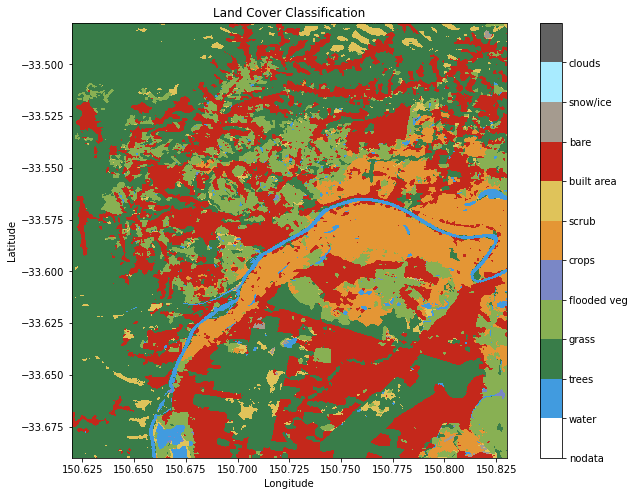

In [13]:
image = land_cover.plot(size=8,cmap=cmap,add_colorbar=False,vmin=0,vmax=class_count)
cbar = plt.colorbar(image)
cbar.set_ticks(range(class_count))
cbar.set_ticklabels(class_names)
plt.gca().set_aspect('equal')
plt.title('Land Cover Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Save the output data in a GeoTIFF file

In [14]:
filename = "Land_Cover_sample2.tiff"

In [15]:
# Set the dimensions of file in pixels
height = land_cover.shape[0]
width = land_cover.shape[1]

In [16]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(min_lon,min_lat,max_lon,max_lat,width,height)
land_cover.rio.write_crs("epsg:4326", inplace=True)
land_cover.rio.write_transform(transform=gt, inplace=True);

In [17]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype=np.ubyte) as dst:
    dst.write(land_cover,1)
    dst.close()

In [18]:
# Show the location and size of the new output file
!ls *.tiff -lah

-rw-rw-r-- 1 jovyan users 122M Jan 19 17:49 DEM_sample.tiff
-rw-r--r-- 1 jovyan users 5.2M Jan 21 18:25 DEM_sample8.tiff
-rw-rw-r-- 1 jovyan users 273K Jan  7 17:21 Land_Cover_sample.tiff
-rw-r--r-- 1 jovyan users 327K Jan 21 19:33 Land_Cover_sample2.tiff
-rw-rw-r-- 1 jovyan users  49M Jan  5 20:26 S2_mosaic_sample.tiff
-rw-r--r-- 1 jovyan users  49M Jan 21 18:40 S2_mosaic_sample2.tiff
-rw-rw-r-- 1 jovyan users  305 Jan  6 01:03 Weather_sample.tiff


### How will the participants use this data?
The GeoTIFF file will contain the Lat-Lon coordinates of each pixel and will also contain the land class for each pixel. Since the FrogID data is also Lat-Lon position, it is possible to find the closest pixel using code similar to what is demonstrated below. Once this pixel is found, then the corresponding land class can be used for modeling species distribution. In addition, participants may want to consider proximity to specific land classes. For example, there may be a positive correlation with land classes such as trees, grass or water and there may be a negative correlation with land classes such as built-up area or bare soil.

These are the possible <b>land classifications</b>, reported below:<br>
1 = water, 2 = trees, 3 = grass, 4 = flooded vegetation, 5 = crops<br>
6 = scrub, 7 = built-up (urban), 8 = bare soil, 9 = snow/ice, 10=clouds

In [19]:
# This is an example for a specific Lon-Lat location randomly selected within our sample region.
values = land_cover.sel(x=150.71, y=-33.51, method="nearest").values    
print("This is the land classification for the closest pixel: ",values)

This is the land classification for the closest pixel:  2
